In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
import re

import collections
import seaborn as sns

In [2]:
#한글 깨짐 처리
import os

if os.name == 'posix':
    plt.rc("font", family="AppleGothic")

else :
    plt.rc("font", family="Malgun Gothic")

%config InlineBackend.figure_format = 'retina'

In [3]:
train = pd.read_csv("capstone_dataset/train.csv")
val = pd.read_csv("capstone_dataset/valid.csv")
test = pd.read_csv("capstone_dataset/test.csv")

In [4]:
train.head()

,id,title,body,category,label
0,AKR20191006026700004,공소시효 만료로 수배 해제 5년간 2만3천건…하루 13건꼴,공소시효가 만료돼 수배가 해제되는 사건이 하루 12∼13건꼴인 것으로 조사됐다. 6...,3,0
1,AKR20190201116900051,설 연휴 부산 병·의원 2천75곳 문 연다,이번 설 연휴 부산에서는 모두 2천75곳의 병·의원이 문을 연다. 부산시는 2일부터...,3,0
2,AKR20200731075300061,"시흥시, 청년근로자 100명에 60만원씩 복지포인트 지급","경기 시흥시는 관내 시흥청년해피기업에 근무하는 청년 근로자 100명을 선정, 1인당...",7,0
3,AKR20191220114000001,"한국당 5일째 패스트트랙法 규탄대회…""4+1, 文정권에 예산뇌물""",자유한국당 황교안 대표와 민주평화당 정동영·정의당 이정미 대표는 4일 상견례 자리에...,1,1
4,AKR20191029112900057,"울산시의원 ""시민 참여 온라인 쇼핑몰 울산몰 만들자""",경남도의회는 11일 제10호 태풍 하이선으로 낙과 피해를 본 밀양시 산내면 사과 재...,1,1


# preprocessing

In [5]:
def preprocessing(text):
    m = Mecab()
    
    cleaned_text = re.sub('[^가-힣]', ' ', text) #한글과 영어 소문자만 남기고 다른 글자 모두 제거
    tokenized_text = m.morphs(cleaned_text)
    removed_by_len_text = [token for token in tokenized_text if len(token)>1]
    return removed_by_len_text

In [6]:
train['title_token'] = train['title'].apply(preprocessing)
train['body_token'] = train['body'].apply(preprocessing)

val['title_token'] = val['title'].apply(preprocessing)
val['body_token'] = val['body'].apply(preprocessing)

KeyboardInterrupt: 

In [105]:
#train['token'] = tokenized_data

In [ ]:
# body 길이 분포 확인
print('body의 최대 길이 :',max(len(review) for review in train['body_token']))
print('body의 평균 길이 :',sum(map(len, train['body_token']))/len(train['body_token']))
plt.hist([len(body) for body in train['body_token']], bins=50)
plt.xlim(0,1000)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
len_token = [len(review) for review in train['body_token']]
len_token = np.array(len_token)
np.percentile(len_token, 95) #value of padding

In [ ]:
len_token = [len(title) for title in train['title_token']]
len_token = np.array(len_token)
np.percentile(len_token, 95) #value of padding

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer() 
tokenized_text = pd.concat([train.body_token,train.title_token],axis=0)
tokenizer.fit_on_texts(tokenized_text)
vocab_size = len(tokenizer.word_index) + 1 # 패딩을 고려하여 +1

In [ ]:
vocab_size

In [ ]:
def encoded_text(tokenizer,tokenized_data,max_len):
    encoded = tokenizer.texts_to_sequences(tokenized_data)
    padded = pad_sequences(encoded, maxlen=max_len)
    return padded

In [ ]:
train_encoded_title_text = encoded_text(tokenizer,train['title_token'],10)
train_encoded_body_text = encoded_text(tokenizer,train['body_token'],415)

val_encoded_title_text = encoded_text(tokenizer,val['title_token'],10)
val_encoded_body_text = encoded_text(tokenizer,val['body_token'],415)

In [115]:
"""
#test용 코드
#title 정수인코딩
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(train['title_token'])
vocab_size = len(tokenizer.word_index) + 1 # 패딩을 고려하여 +1
X_encoded = tokenizer.texts_to_sequences(tokenized_data)
X_padded = pad_sequences(X_encoded, maxlen=419)
"""

"\n#test용 코드\n#title 정수인코딩\ntokenizer = Tokenizer() \ntokenizer.fit_on_texts(train['title_token'])\nvocab_size = len(tokenizer.word_index) + 1 # 패딩을 고려하여 +1\nX_encoded = tokenizer.texts_to_sequences(tokenized_data)\nX_padded = pad_sequences(X_encoded, maxlen=419)\n"

In [116]:
"""
#test용 코드
#body text 정수인코딩
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(tokenized_data)
vocab_size = len(tokenizer.word_index) + 1 # 패딩을 고려하여 +1
X_encoded = tokenizer.texts_to_sequences(tokenized_data)
X_padded = pad_sequences(X_encoded, maxlen=419)
"""

'\n#test용 코드\n#body text 정수인코딩\ntokenizer = Tokenizer() \ntokenizer.fit_on_texts(tokenized_data)\nvocab_size = len(tokenizer.word_index) + 1 # 패딩을 고려하여 +1\nX_encoded = tokenizer.texts_to_sequences(tokenized_data)\nX_padded = pad_sequences(X_encoded, maxlen=419)\n'

# word2vec
- headline과 body-text의 tokenization을 합쳐서 학습

In [117]:
import gensim
from gensim.models import Word2Vec
#pretrained_model
model = gensim.models.Word2Vec.load('/Users/saeran/Desktop/SJU2022/캡스톤/word2vecKo/ko.bin')
model.wv.save_word2vec_format('ko.bin.gz') #저장하지않으면, 나중에 Intersect시에 codec오류가 있음

In [118]:
from gensim.models import Word2Vec, KeyedVectors

w2v = Word2Vec(size=200, min_count=1)#news data로 학습
w2v.build_vocab(tokenized_text, update=True)
w2v.intersect_word2vec_format("ko.bin.gz", binary=False)
w2v.train(tokenized_text, total_examples=len(tokenized_text), epochs=5) 

In [119]:
"""
#이전에 했던 방식
w2v = Word2Vec(size=200, min_count=1)#news data로 학습
w2v.build_vocab([tokenized_text], update=True)

w2v.build_vocab([list(model.wv.vocab.keys())], update=True)
w2v.intersect_word2vec_format("ko.bin.gz", binary=False)
w2v.train(tokenized_text, total_examples=len(tokenized_text), epochs=5)
"""

<ipython-input-119-e032f843510d>:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  w2v.train(tokenized_text, total_examples=total_examples, epochs=w2v.iter)


(94727765, 94798630)

In [ ]:
"""
#워드임베딩
import gensim
from gensim.models import Word2Vec, KeyedVectors

#1. load pretrained_model
model = gensim.models.Word2Vec.load('/Users/saeran/Desktop/SJU2022/캡스톤/word2vecKo/ko.bin')
model.wv.save_word2vec_format('ko.bin.gz') #저장하지않으면, 나중에 Intersect시에 codec오류가 있음

#2. train with body text-data
w2v = Word2Vec(size=200, min_count=1)
w2v.build_vocab(train.token)
total_examples = w2v.corpus_count #우리가 필요한 vocabulary는 현재 뉴스데이터에 대한 것이어야함.

#3. intersect with pre-trained model
w2v.build_vocab([list(model.wv.vocab.keys())], update=True)
w2v.intersect_word2vec_format("ko.bin.gz", binary=False)
w2v.train(tokenized_text, total_examples=total_examples, epochs=w2v.iter)
"""

In [120]:
print('모델의 크기(shape) :',w2v.wv.vectors.shape) # 모델의 크기 확인

모델의 크기(shape) : (132876, 200)


In [121]:
w2v.save('word2vec_ko.bin') #임베딩 모델 저장하기

# FastText

In [ ]:
import gensim
from gensim import models
from gensim.models import fasttext
from gensim.models import Word2Vec, KeyedVectors

In [ ]:
ft_model = fasttext.load_facebook_model('/Users/saeran/Desktop/SJU2022/캡스톤/fasttext_wiki.ko/wiki.ko.bin')
ft_model.build_vocab(sentences=tokenized_text, update=True)
ft_model.train(tokenized_text, total_examples=len(tokenized_text),epochs=5)

In [ ]:
ft_model.similar_by_word('병원')

In [ ]:
embedding_matrix = np.zeros((vocab_size, 200)) #200차원의 임베딩 매트릭스 생성

for word,index in tokenizer.word_index.items(): #vocabulary에 있는 토큰들을 하나씩 넘겨줍니다.
    if word in w2v: #넘겨 받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 뜻)
        embedding_vector = w2v[word] #해당 토큰에 해당하는 vector를 불러오고
        embedding_matrix[index] = embedding_vector #해당 위치의 embedding_mxtrix에 저장합니다.
    else:
        print(word)
        print("word2vec에 없는 단어입니다.")
        break

In [ ]:
len(tokenizer.word_index)

In [ ]:
print(w2v.wv.similar_by_word('의원'))

# LSTM

In [125]:
import tensorflow as tf
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

from keras.callbacks import ModelCheckpoint,EarlyStopping


from keras.models import Model
from keras import layers
from keras import Input

from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [127]:
X_train_title, X_val_title = train.train_encoded_title_text, val.val_encoded_title_text
X_train_body, X_val_body = train.train_encoded_body_text, val.val_encoded_body_text
y_train, y_val = train.label.values, val.label.values

In [ ]:
X_train_title.shape, X_val_title.shape,X_train_body.shape,X_val_body.shape, y_train.shape, y_val.shape

In [128]:
X_train_title.shape, X_val_title.shape

((80000, 10), (20000, 10))

In [129]:
embedding_matrix.shape

(127860, 200)

In [138]:
#lstm - output

#title 입력층
input_title = Input(shape=(10,),name="title",dtype='int32')
embedded_title = layers.Embedding(vocab_size, 200,weights = [embedding_matrix], input_length = 11,trainable=False)(input_title)
encoded_title = layers.LSTM(64)(embedded_title)
#body 입력층
input_body = Input(shape=(415,),name="body",dtype='int32')
embedded_body = layers.Embedding(vocab_size, 200,weights = [embedding_matrix], input_length = 419,trainable=False)(input_body)
encoded_body = layers.LSTM(64)(embedded_body)

#title + body
concatenated = layers.concatenate([encoded_title,encoded_body])

#dense
layer1 = layers.Dense(10,activation='relu')(concatenated)
layer2 = layers.Dense(5,activation='relu')(layer1)

#분류
output = layers.Dense(1, activation='sigmoid')(layer2)

model = Model(inputs=[input_title,input_body],outputs=output)
model.summary()

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 10)]         0           []                               
                                                                                                  
 body (InputLayer)              [(None, 415)]        0           []                               
                                                                                                  
 embedding_30 (Embedding)       (None, 10, 200)      25572000    ['title[0][0]']                  
                                                                                                  
 embedding_31 (Embedding)       (None, 415, 200)     25572000    ['body[0][0]']                   
                                                                                           

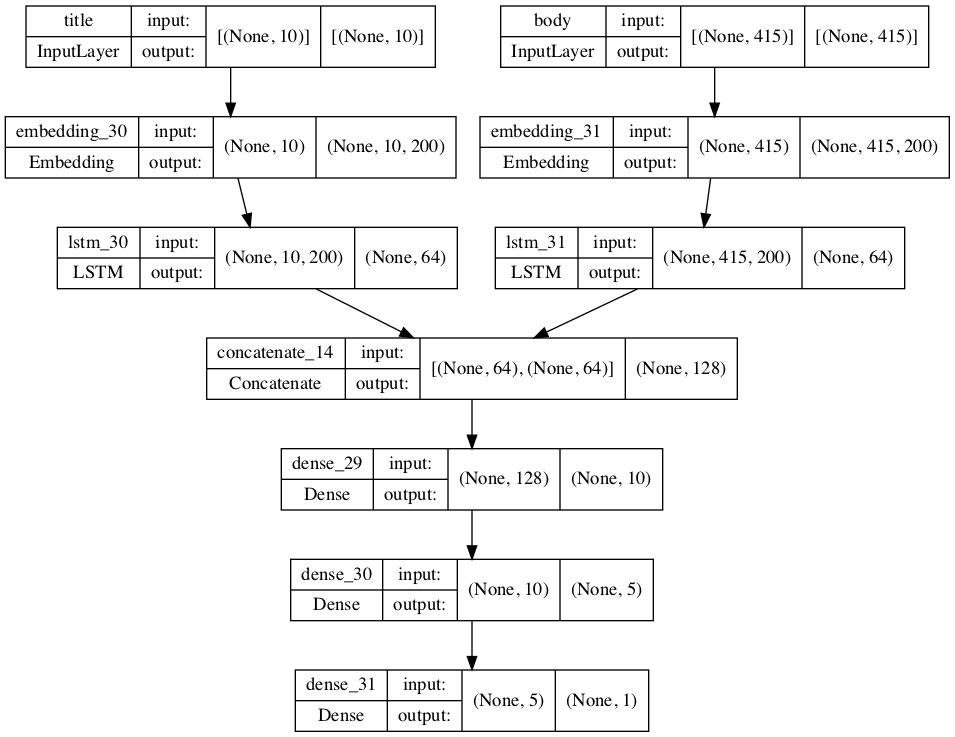

In [139]:
keras.utils.plot_model(model,show_shapes=True)

In [140]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit({'title':X_train_title,'body':X_train_body}, y_train, epochs=10, batch_size=256, verbose=1,callbacks=[es,mc],validation_data=[[X_val_title,X_val_body],y_val])

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.6862 - acc: 0.5473
Epoch 1: val_acc improved from -inf to 0.60055, saving model to best_model.h5
313/313 [==============================] - 397s 1s/step - loss: 0.6862 - acc: 0.5473 - val_loss: 0.6734 - val_acc: 0.6005
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.6419 - acc: 0.6559
Epoch 2: val_acc improved from 0.60055 to 0.67190, saving model to best_model.h5
313/313 [==============================] - 395s 1s/step - loss: 0.6419 - acc: 0.6559 - val_loss: 0.6285 - val_acc: 0.6719
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.5925 - acc: 0.7113
Epoch 3: val_acc improved from 0.67190 to 0.70575, saving model to best_model.h5
313/313 [==============================] - 389s 1s/step - loss: 0.5925 - acc: 0.7113 - val_loss: 0.5922 - val_acc: 0.7057
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.5418 - acc: 0.7510
Epoch 4: val_acc improved from

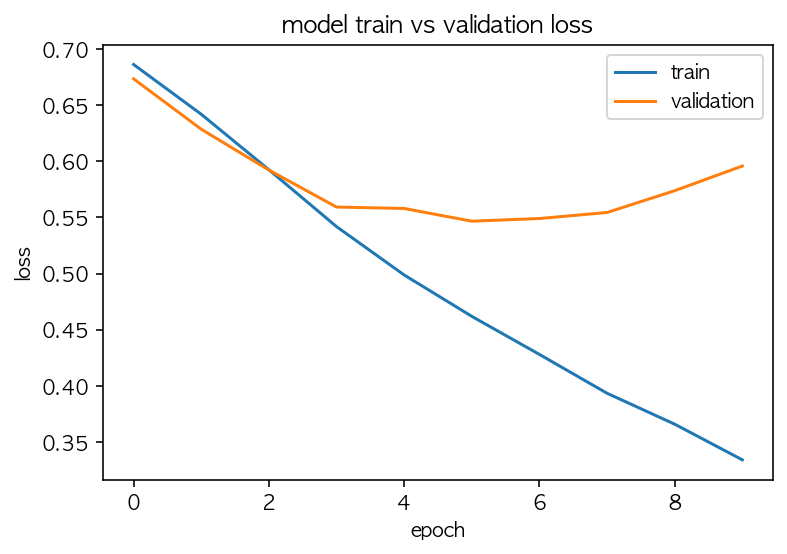

In [141]:
#Diagnostic Plots
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [142]:
pd.DataFrame(history.history)

,loss,acc,val_loss,val_acc
0,0.686168,0.547325,0.673388,0.60055
1,0.641868,0.655900,0.628533,0.67190
2,0.592468,0.711250,0.592186,0.70575
3,0.541818,0.751013,0.559227,0.73225
4,0.498773,0.777075,0.557970,0.72465
5,0.461908,0.796525,0.546630,0.73855
6,0.428002,0.815475,0.549008,0.74130
7,0.393418,0.834275,0.554367,0.75105
8,0.365884,0.847300,0.573781,0.73505
9,0.334132,0.865325,0.595770,0.74510


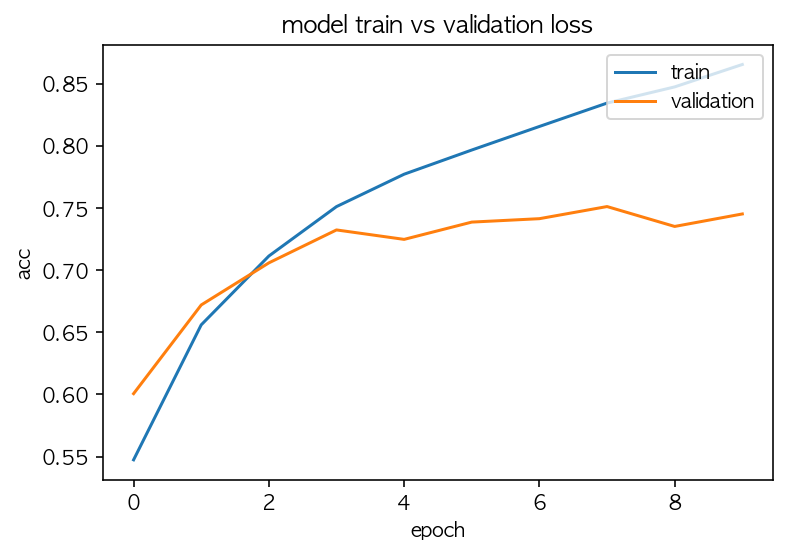

In [143]:
#Diagnostic Plots
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
#정성적 평가하기
